In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ai-vs-human-text/AI_Human.csv


In [2]:
import numpy as np 
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_curve, auc


In [3]:
df1=pd.read_csv('/kaggle/input/ai-vs-human-text/AI_Human.csv')

In [4]:
df1

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0
...,...,...
487230,Tie Face on Mars is really just a big misunder...,0.0
487231,The whole purpose of democracy is to create a ...,0.0
487232,I firmly believe that governments worldwide sh...,1.0
487233,I DFN't agree with this decision because a LFT...,0.0


In [5]:
df_human=df1[df1['generated']==0.0]

In [6]:
df_human['text_length']=[len(s) for s in df_human['text']]

<ipython-input-6-f2aec1d6cc04>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_human['text_length']=[len(s) for s in df_human['text']]


In [7]:
df_ai=df1[df1['generated']==1.0]

In [8]:
df_ai['text_length']=[len(s) for s in df_ai['text']]

<ipython-input-8-4c5a60bd5818>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ai['text_length']=[len(s) for s in df_ai['text']]


In [9]:
df_human['text_length'].mean()

2354.592837732221

In [10]:
df_ai['text_length'].mean()

2126.316411115643

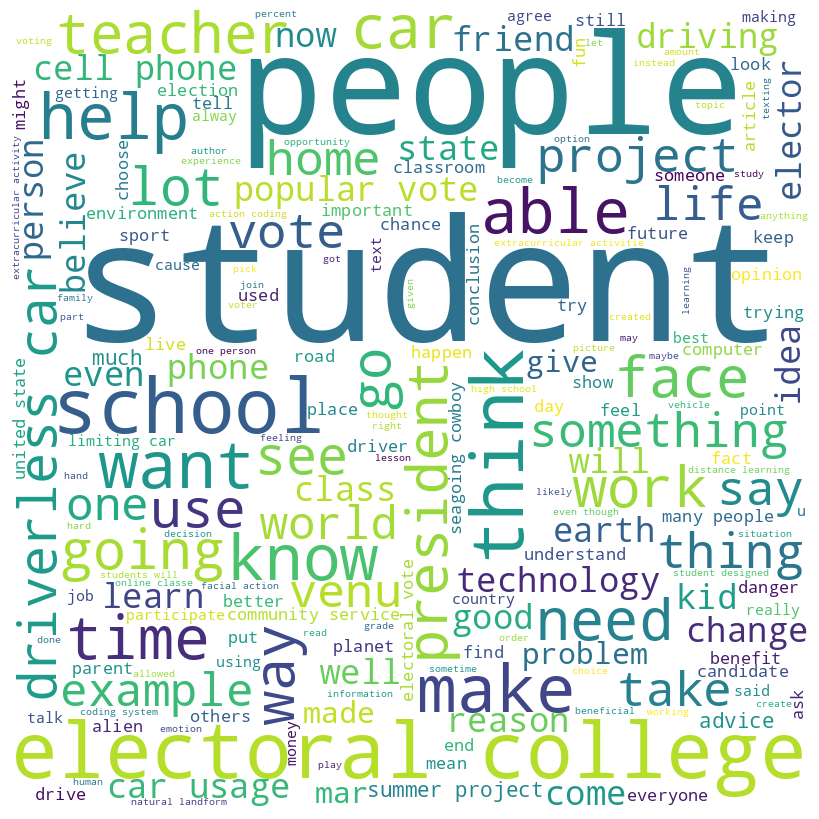

In [11]:
# Initialize variables
words = ''
stopwords = set(STOPWORDS)

# Iterate through the CSV file
for sentence in df_human['text']:
    # Typecast each value to string
    sentence = str(sentence)

    # Split the value
    tokens = sentence.split()

    # Convert each token to lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    words += " ".join(tokens) + " "

# Generate the WordCloud
wordcloud = WordCloud(width=800, height=800,
                       background_color='white',
                       stopwords=stopwords,
                       min_font_size=10).generate(words)

# Plot the WordCloud image					 
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()


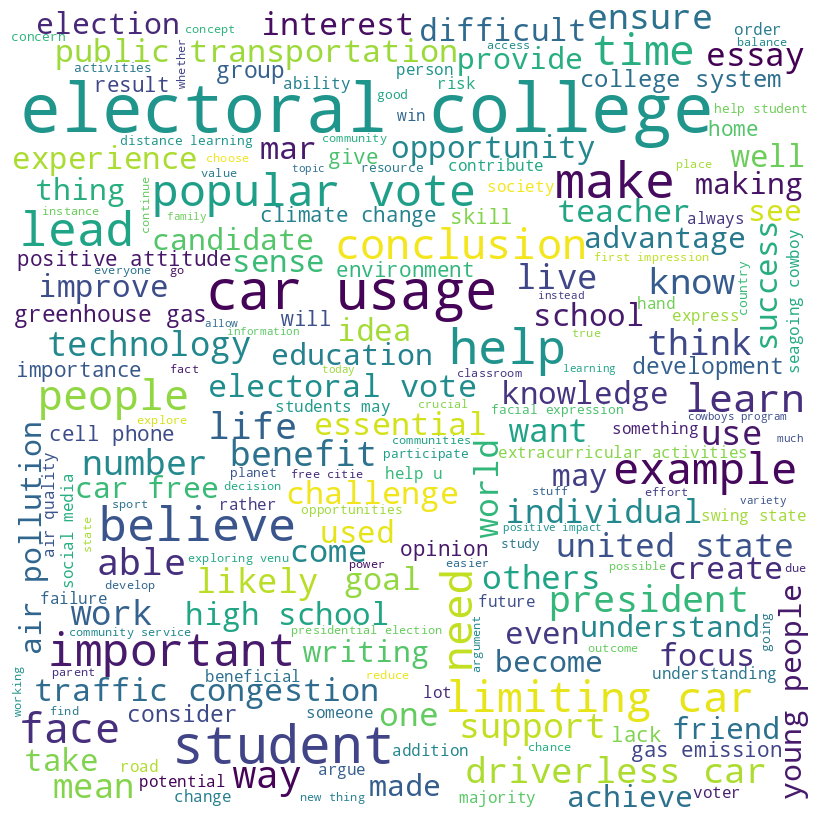

In [12]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Initialize variables
words = ''
stopwords = set(STOPWORDS)

# Iterate through the CSV file
for sentence in df_ai['text']:
    # Typecast each value to string
    sentence = str(sentence)

    # Split the value
    tokens = sentence.split()

    # Convert each token to lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    words += " ".join(tokens) + " "

# Generate the WordCloud
wordcloud = WordCloud(width=800, height=800,
                       background_color='white',
                       stopwords=stopwords,
                       min_font_size=10).generate(words)

# Plot the WordCloud image					 
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()


# Analysis from the word cloud
### 1) The word clouds clearly show that both AI genrated and human genrated texts are mostly related to same topics
### 2) The vocabulary used by humans seem to be less diversed and makes some word more dominant than others. Whereas AI genrated text has uniform distribution of vocabulary. This observation suggests that there will be a clear distinction betweeen ai text and human text and that we will be getting and so models will find it easy to classify them.


# Model 1
### We will be using simple XGB classifier first. The word cloud and average length shows that there is a clear distinction between
### both vocabularies. For XGB classifier, we will be also using the len(text) feature


In [13]:
df1['text_length']=[len(s) for s in df1['text']]

In [14]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df1, stratify=df1['generated'], test_size=0.2, random_state=42)



In [15]:
df_train

,text,generated,text_length
20544,There are a number of different opinions on wh...,1.0,2194
479611,"""Resent studies suggest that Americans are buy...",0.0,2533
209335,Technology has revolutionized the way we live ...,1.0,2509
472449,Bdvanatges of limiting car usage would be very...,0.0,955
36191,Title: Exploring Venus: A Journey Through Eart...,1.0,2797
...,...,...,...
377586,Many people believe that the production of dri...,0.0,3179
112389,The Face on Mars is just a natural landform. I...,0.0,1343
345857,Studying Venus is a worthy pursuit despite the...,0.0,1728
61949,"Dear Principal,\n\nI feel that it would be wro...",0.0,924


In [16]:
import nltk
import re
import pandas as pd
from nltk.corpus import stopwords

# Ensure stopwords are downloaded
nltk.download('stopwords')

def _text_cleaning(df, col, col1):
    stop_words = set(stopwords.words('english'))  
    
    df[col1] = df[col].astype(str).apply(lambda text: ' '.join(
        [word for word in re.sub(r'[^a-z\s]', '', text.lower()).split() if word not in stop_words]
    ))
    
    return df


    
    
  

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
df_train=_text_cleaning(df_train,'text','cleaned_text')

In [18]:
df_train

,text,generated,text_length,cleaned_text
20544,There are a number of different opinions on wh...,1.0,2194,number different opinions primary purpose univ...
479611,"""Resent studies suggest that Americans are buy...",0.0,2533,resent studies suggest americans buying fewer ...
209335,Technology has revolutionized the way we live ...,1.0,2509,technology revolutionized way live daily lives...
472449,Bdvanatges of limiting car usage would be very...,0.0,955,bdvanatges limiting car usage would useful mul...
36191,Title: Exploring Venus: A Journey Through Eart...,1.0,2797,title exploring venus journey earths mysteriou...
...,...,...,...,...
377586,Many people believe that the production of dri...,0.0,3179,many people believe production driverless cars...
112389,The Face on Mars is just a natural landform. I...,0.0,1343,face mars natural landform think face evidence...
345857,Studying Venus is a worthy pursuit despite the...,0.0,1728,studying venus worthy pursuit despite dangers ...
61949,"Dear Principal,\n\nI feel that it would be wro...",0.0,924,dear principal feel would wrong passed policy ...


# Embeddings to try 
## 1) tf-idf vectorization
## 2) glove vectorization
## 3) my favourite gemini embeddings


In [19]:
nltk.download('wordnet')
nltk.download('corpora')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Error loading corpora: Package 'corpora' not found in
[nltk_data]     index


False

In [20]:
df_train

,text,generated,text_length,cleaned_text
20544,There are a number of different opinions on wh...,1.0,2194,number different opinions primary purpose univ...
479611,"""Resent studies suggest that Americans are buy...",0.0,2533,resent studies suggest americans buying fewer ...
209335,Technology has revolutionized the way we live ...,1.0,2509,technology revolutionized way live daily lives...
472449,Bdvanatges of limiting car usage would be very...,0.0,955,bdvanatges limiting car usage would useful mul...
36191,Title: Exploring Venus: A Journey Through Eart...,1.0,2797,title exploring venus journey earths mysteriou...
...,...,...,...,...
377586,Many people believe that the production of dri...,0.0,3179,many people believe production driverless cars...
112389,The Face on Mars is just a natural landform. I...,0.0,1343,face mars natural landform think face evidence...
345857,Studying Venus is a worthy pursuit despite the...,0.0,1728,studying venus worthy pursuit despite dangers ...
61949,"Dear Principal,\n\nI feel that it would be wro...",0.0,924,dear principal feel would wrong passed policy ...


In [21]:
# Split the dataset first before feature extraction
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df_train[['cleaned_text', 'text_length']], df_train['generated'], 
    test_size=0.2, random_state=42, stratify=df_train['generated']
)

# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=1000)

# Fit on training data and transform both train and test sets
X_train_tfidf = vectorizer.fit_transform(X_train_text['cleaned_text']).toarray()
X_test_tfidf = vectorizer.transform(X_test_text['cleaned_text']).toarray()

# Combine TF-IDF vectors with the text_length feature
X_train_combined = np.hstack([X_train_tfidf, X_train_text[['text_length']].values])
X_test_combined = np.hstack([X_test_tfidf, X_test_text[['text_length']].values])

# Train an XGBoost classifier
model = XGBClassifier()
model.fit(X_train_combined, y_train)




XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [22]:
import seaborn as sns

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     48928
         1.0       1.00      0.99      0.99     29030

    accuracy                           1.00     77958
   macro avg       1.00      0.99      0.99     77958
weighted avg       1.00      1.00      1.00     77958


Confusion Matrix:
[[48857    71]
 [  295 28735]]


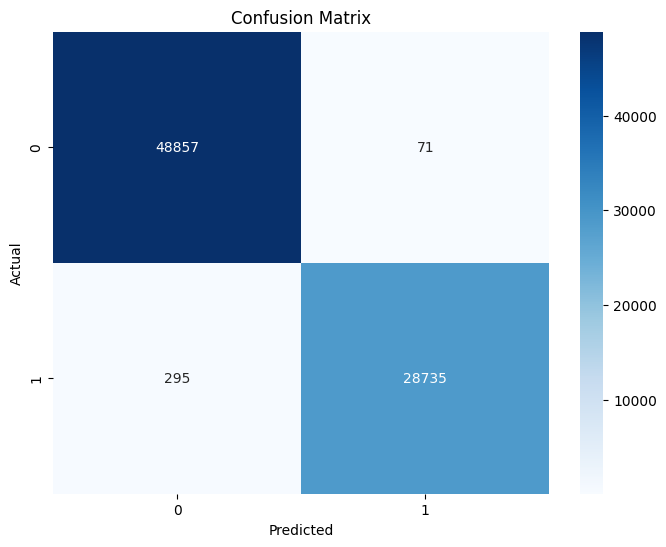

In [23]:


# Make predictions on the test set
y_pred = model.predict(X_test_combined)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [24]:
df_train['generated'].value_counts()

generated
0.0    244638
1.0    145150
Name: count, dtype: int64

In [25]:
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_pos_weight = neg_count / pos_count


model = XGBClassifier(scale_pos_weight=scale_pos_weight)
model.fit(X_train_combined, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     48928
         1.0       1.00      0.99      0.99     29030

    accuracy                           1.00     77958
   macro avg       1.00      1.00      1.00     77958
weighted avg       1.00      1.00      1.00     77958


Confusion Matrix:
[[48817   111]
 [  192 28838]]


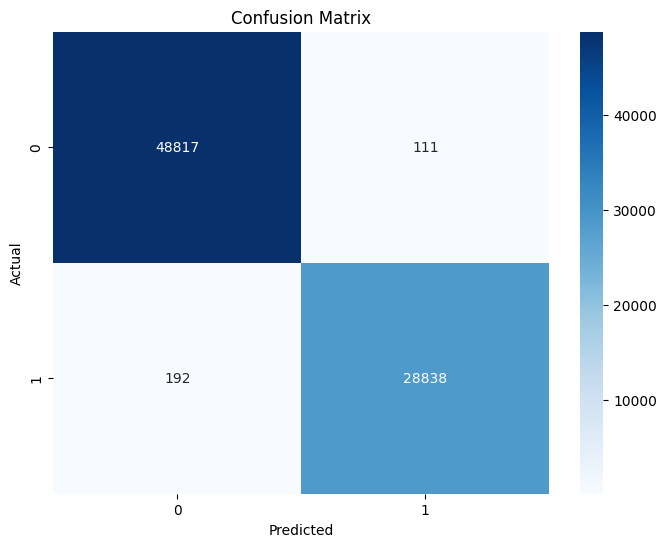

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = model.predict(X_test_combined)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [27]:
df_test

,text,generated,text_length
470094,Do you think the Facial Action Coding is 100 P...,0.0,2453
281303,I believe that it is more important for studen...,1.0,866
484061,Changing the school's cafeteria may to health...,1.0,1346
107427,Those who consider having many experiences to ...,1.0,1280
236976,Summer break is meant for fun and time with fa...,0.0,5856
...,...,...,...
280407,Making one's own decisions is a critical step ...,1.0,1230
334146,"As an eighth grade student, I believe that sch...",1.0,2624
379382,Summer assignments are widely used throughout ...,0.0,4801
22116,There is no one answer to this question as it ...,1.0,1178


In [28]:
df_test=_text_cleaning(df_test,'text','cleaned_text')

In [29]:
y_test=df_test['generated']


In [30]:
X_test_tfidf = vectorizer.transform(df_test['cleaned_text']).toarray()


In [31]:
X_test_combined = np.hstack([X_test_tfidf, df_test[['text_length']].values])

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     61159
         1.0       1.00      0.99      0.99     36288

    accuracy                           1.00     97447
   macro avg       1.00      1.00      1.00     97447
weighted avg       1.00      1.00      1.00     97447


Confusion Matrix:
[[60983   176]
 [  204 36084]]


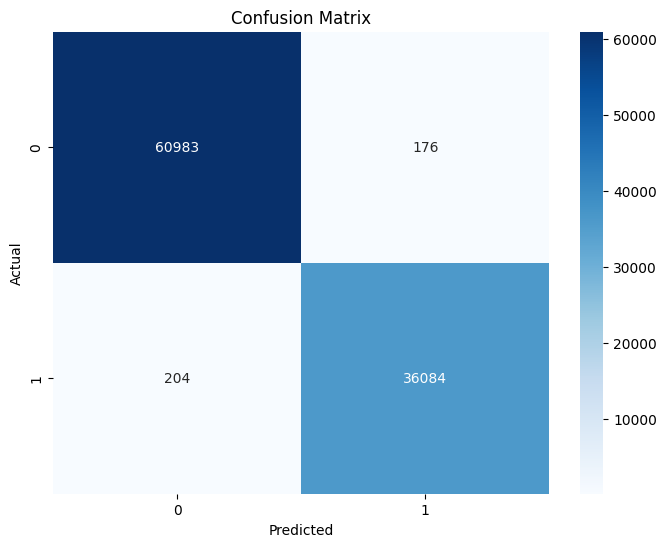

In [32]:
y_pred = model.predict(X_test_combined)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [33]:


accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")



# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test_combined)[:, 1])

# Area under PR curve
pr_auc = auc(recall, precision)
print(f"\nArea Under Precision-Recall Curve (PR AUC): {pr_auc:.4f}")

Accuracy: 0.9961

Area Under Precision-Recall Curve (PR AUC): 0.9998


In [34]:
test_text_1='''Cars are one of the major contributors to environmental pollution, releasing harmful emissions that significantly impact air quality and contribute to climate change. The combustion of fossil fuels in car engines produces pollutants such as carbon dioxide (CO2), nitrogen oxides (NOx), particulate matter, and volatile organic compounds (VOCs). CO2, a greenhouse gas, is the primary driver of global warming, while NOx and particulate matter can cause respiratory issues and other health problems. Additionally, the production and disposal of vehicles generate waste and consume vast amounts of resources. The growing adoption of electric vehicles and advancements in clean energy technologies are essential steps toward reducing the environmental footprint of transportation and protecting our planet for future generations.'''

In [35]:

test_text ='''Regardless of what you drive, you can make sure your car runs as clean and efficiently as possible. Maintain your vehicle and keep it in good repair. Follow your owner's manual and make sure you schedule regular oil changes and other maintenance.

Newer vehicles have very complex emission controls to keep them running as clean as possible. If any of these controls are not functioning as designed, your vehicle will pollute more than it should. A check engine light on your dashboard means your vehicle is not operating as designed and needs repairs or maintenance. You should take your vehicle to a qualified automotive technician.

Keeping your tires properly inflated makes your vehicle run more efficiently and burn less fuel. You will find the correct tire pressure for your vehicle in your owner's manual.

Drive smarter
The way you drive can also influence how much pollution comes from your vehicle. Observing posted speed limits is one way to reduce pollution, and it's safer. Driving faster burns more fuel and emits more air pollutants. Accelerating gradually also burns less fuel. Getting a vehicle moving from a complete stop uses the most energy, so go easy on the accelerator. Try to anticipate the road ahead and avoid racing from red light to red light. Instead, strive to maintain a steady speed with less stop and go driving.
'''
# Create a DataFrame to apply the cleaning function
test_df = pd.DataFrame([test_text], columns=['text'])
# Text cleaning using your custom function
test_df = _text_cleaning(test_df, 'text', 'cleaned_text')

# TF-IDF transformation for the cleaned text
test_tfidf = vectorizer.transform(test_df['cleaned_text']).toarray()

# Compute the text length feature
test_text_length = len(test_text)

# Combine TF-IDF vector with text_length
test_features = np.append(test_tfidf, test_text_length).reshape(1, -1)

# Make prediction using the trained model
prediction = model.predict(test_features)
prediction_proba = model.predict_proba(test_features)[:, 1]

print(f"Prediction: {prediction[0]}")
print(f"Prediction Probability: {prediction_proba[0]:.4f}")


Prediction: 0
Prediction Probability: 0.4883


# Evaluation analysis
### The model seems to work well on both train and test sets. As well as it is predicting well on real life data.
### The dataset seems to be easy but it can be that AI genrated text and non ai genrated text may have easier to identify differences


In [36]:
import xgboost
print(xgboost.__version__)


2.0.3


In [37]:
import joblib

# Save the vectorizer
joblib.dump(vectorizer, "tfidf_vectorizer.joblib")

# Save the model
joblib.dump(model, "xgb_model.joblib")


['xgb_model.joblib']